In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, LeakyReLU
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [2]:
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')
    
np.random.seed(3)
tf.random.set_seed(3)

In [3]:
#생성자 모델
generator = models.Sequential()
generator.add(Dense(7*7*128, input_dim=100, activation=layers.LeakyReLU(0.2))) # 7by7 에 채널이 128개
generator.add(layers.BatchNormalization()) #학습의 효율을 높이기 위해 스케일링을 줄임
generator.add(layers.Reshape((7,7,128))) 

#1차원은 백터 2차원은 매트릭스 3차원이상은 tensor이라고 부름
generator.add(layers.UpSampling2D()) #차원계산이 중요함  픽셀하나를 동일한 픽셀 4개로 만듦 총면적이 4배로 커짐
generator.add(layers.Conv2D(64, kernel_size=5, padding='same'))
generator.add(layers.BatchNormalization())
generator.add(layers.Activation(LeakyReLU(0.2)))
generator.add(layers.UpSampling2D()) 
generator.add(layers.Conv2D(1, kernel_size=5, padding='same', activation='tanh')) #가짜그림 한 장을 만듦

In [4]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0

In [5]:
#판별자 모델
discriminator = models.Sequential()
discriminator.add(layers.Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1)
                               , padding='same')) #커널을 2픽셀씩 가게하는 의미
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1, activation='sigmoid')) #진짜냐 가짜냐

In [6]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
activation_2 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [7]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False # 위조지폐와 경찰 그림과 같이노이즈로 만든 그림을 날렸을 때 오차를 리턴할 경우 학습을할 때 생성자 학습할 때는 기본 학습을 막아버리는 것
#가중치와 바이어스 갱신 x

In [8]:
ginput = layers.Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = models.Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [9]:
def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float)
    X_train = (X_train - 127.5) / 127.5 
    # 네트워크를 thnh로 만들었기에 -1~1사이값으로 만듦
    
    true = np.ones((batch_size, 1)) #1로채워진 numpy배열
    fake = np.zeros((batch_size, 1)) #0으로 채워진 배열
    
    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true) #역전파도 이루어짐
        
        noise = np.random.normal(0, 1,(batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)#가짜라고 discriminator
        #제너레이터를 훈련시키는 것
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        
        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)
        
        if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("gan_images/gan_mnist_%d.png" % i)

In [ ]:
def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data() # 변수를 받지 않기 위해 _ 로 비움
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float) 
    # 가로 28, 세로 28 픽셀이고 흑백이므로 1을 설정
    # 28, 28, 1 채널로 reshape
    
    X_train = (X_train - 127.5) / 127.5
    # 0~255 사이의 픽셀의 grayscale 값이 -1~1 로 변한다
    # 활성화 함수가 tanh (픽셀값을 -1~1)이므로 해당 값으로 맞춰줘야 한다.
    
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        # idx = o부터 X_train 길이에서 batch_size 만큼 랜덤하게 가져온 숫자
        imgs = X_train[idx]
        
        d_loss_real = discriminator.train_on_batch(imgs, true)
        # train_on_batch(x, y) 함수는 입력 값(x)과 레이블(y)을 받아서 딱 한 번 학습을 실시해 모델을 업데이트
        # 역전파도 이루어진다
        # 진짜를 판단하는데 생기는 손실
        
        noise = np.random.normal(0, 1, (batch_size, 100)) # 0~1 사이에서 batch_size만큼 100개
        
        gen_imgs = generator.predict(noise)
        
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        # 가짜를 판단하는데 생기는 손실
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        # generator는 혼자서 진위여부를 판단할 수 없기 때문에 gan network 를 통째로 사용
        
        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)
            
        if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("gan_images/gan_mnist_%d.png" % i)

epoch:0  d_loss:0.7058  g_loss:0.6951
epoch:1  d_loss:0.4413  g_loss:0.3196
epoch:2  d_loss:0.5600  g_loss:0.0881
epoch:3  d_loss:0.6929  g_loss:0.0671
epoch:4  d_loss:0.6343  g_loss:0.1406
epoch:5  d_loss:0.5153  g_loss:0.4003
epoch:6  d_loss:0.4915  g_loss:0.7275
epoch:7  d_loss:0.5085  g_loss:0.9198
epoch:8  d_loss:0.4961  g_loss:0.9487
epoch:9  d_loss:0.4660  g_loss:0.8993
epoch:10  d_loss:0.3933  g_loss:0.9078
epoch:11  d_loss:0.3744  g_loss:0.9049
epoch:12  d_loss:0.3859  g_loss:0.9368
epoch:13  d_loss:0.3799  g_loss:0.9746
epoch:14  d_loss:0.5279  g_loss:0.9183
epoch:15  d_loss:0.5502  g_loss:1.0330
epoch:16  d_loss:0.4738  g_loss:1.0085
epoch:17  d_loss:0.6390  g_loss:0.6969
epoch:18  d_loss:0.5955  g_loss:0.5644
epoch:19  d_loss:0.5489  g_loss:0.6185
epoch:20  d_loss:0.5270  g_loss:0.8096
epoch:21  d_loss:0.5049  g_loss:0.9554
epoch:22  d_loss:0.5703  g_loss:0.6974
epoch:23  d_loss:0.5258  g_loss:0.7240
epoch:24  d_loss:0.4716  g_loss:0.7544
epoch:25  d_loss:0.5209  g_loss:0.7

epoch:208  d_loss:0.5270  g_loss:1.7936
epoch:209  d_loss:0.2868  g_loss:2.0670
epoch:210  d_loss:0.4475  g_loss:1.9887
epoch:211  d_loss:0.3646  g_loss:2.2607
epoch:212  d_loss:0.4176  g_loss:2.3061
epoch:213  d_loss:0.5141  g_loss:2.1278
epoch:214  d_loss:0.5060  g_loss:1.8281
epoch:215  d_loss:0.4621  g_loss:1.8711
epoch:216  d_loss:0.5905  g_loss:1.7259
epoch:217  d_loss:0.4657  g_loss:1.5967
epoch:218  d_loss:0.5411  g_loss:1.6181
epoch:219  d_loss:0.6132  g_loss:1.7424
epoch:220  d_loss:0.4763  g_loss:1.8133
epoch:221  d_loss:0.6485  g_loss:1.7993
epoch:222  d_loss:0.7062  g_loss:1.8954
epoch:223  d_loss:0.6857  g_loss:1.7014
epoch:224  d_loss:0.7080  g_loss:1.4240
epoch:225  d_loss:0.6459  g_loss:1.4569
epoch:226  d_loss:0.5683  g_loss:1.6199
epoch:227  d_loss:0.6935  g_loss:1.6180
epoch:228  d_loss:0.5623  g_loss:1.8420
epoch:229  d_loss:0.4812  g_loss:1.9978
epoch:230  d_loss:0.5623  g_loss:1.7752
epoch:231  d_loss:0.6048  g_loss:1.8542
epoch:232  d_loss:0.5595  g_loss:1.7798


epoch:413  d_loss:0.3445  g_loss:1.7776
epoch:414  d_loss:0.4248  g_loss:1.7924
epoch:415  d_loss:0.3135  g_loss:2.2565
epoch:416  d_loss:0.3406  g_loss:2.1602
epoch:417  d_loss:0.3358  g_loss:1.9974
epoch:418  d_loss:0.2683  g_loss:2.1096
epoch:419  d_loss:0.4235  g_loss:2.0121
epoch:420  d_loss:0.2625  g_loss:2.3590
epoch:421  d_loss:0.2646  g_loss:2.5456
epoch:422  d_loss:0.4252  g_loss:2.0200
epoch:423  d_loss:0.3984  g_loss:2.2321
epoch:424  d_loss:0.3474  g_loss:2.4614
epoch:425  d_loss:0.2816  g_loss:2.6637
epoch:426  d_loss:0.3485  g_loss:2.3680
epoch:427  d_loss:0.3032  g_loss:2.2777
epoch:428  d_loss:0.3765  g_loss:2.3496
epoch:429  d_loss:0.2999  g_loss:1.9713
epoch:430  d_loss:0.3042  g_loss:2.0706
epoch:431  d_loss:0.2280  g_loss:2.4475
epoch:432  d_loss:0.3173  g_loss:2.6537
epoch:433  d_loss:0.4142  g_loss:2.2131
epoch:434  d_loss:0.3846  g_loss:2.4787
epoch:435  d_loss:0.3933  g_loss:2.0655
epoch:436  d_loss:0.3425  g_loss:1.8756
epoch:437  d_loss:0.2988  g_loss:2.2123


epoch:618  d_loss:0.5887  g_loss:2.5274
epoch:619  d_loss:0.4141  g_loss:2.1820
epoch:620  d_loss:0.3654  g_loss:2.4832
epoch:621  d_loss:0.2960  g_loss:2.4886
epoch:622  d_loss:0.3532  g_loss:2.4730
epoch:623  d_loss:0.1774  g_loss:2.6803
epoch:624  d_loss:0.3260  g_loss:1.7756
epoch:625  d_loss:0.2490  g_loss:1.0026
epoch:626  d_loss:0.8204  g_loss:0.9766
epoch:627  d_loss:0.6626  g_loss:0.8725
epoch:628  d_loss:0.6146  g_loss:0.7611
epoch:629  d_loss:0.6285  g_loss:1.3531
epoch:630  d_loss:1.0743  g_loss:1.3734
epoch:631  d_loss:0.6514  g_loss:2.4226
epoch:632  d_loss:0.9257  g_loss:3.0146
epoch:633  d_loss:0.3132  g_loss:3.7133
epoch:634  d_loss:0.2547  g_loss:4.1003
epoch:635  d_loss:0.2171  g_loss:3.8169
epoch:636  d_loss:0.2049  g_loss:4.5516
epoch:637  d_loss:0.6561  g_loss:4.4182
epoch:638  d_loss:0.4872  g_loss:5.4175
epoch:639  d_loss:1.0832  g_loss:4.3470
epoch:640  d_loss:2.8134  g_loss:2.8055
epoch:641  d_loss:2.1016  g_loss:1.7855
epoch:642  d_loss:0.6250  g_loss:3.1858


epoch:823  d_loss:0.3943  g_loss:2.0236
epoch:824  d_loss:0.4275  g_loss:2.2939
epoch:825  d_loss:0.4637  g_loss:2.5327
epoch:826  d_loss:0.4847  g_loss:2.1736
epoch:827  d_loss:0.5111  g_loss:1.6847
epoch:828  d_loss:0.3627  g_loss:1.9117
epoch:829  d_loss:0.5595  g_loss:1.8701
epoch:830  d_loss:0.2618  g_loss:2.4464
epoch:831  d_loss:0.5121  g_loss:2.3548
epoch:832  d_loss:0.4034  g_loss:2.2273
epoch:833  d_loss:0.3017  g_loss:2.4908
epoch:834  d_loss:0.4964  g_loss:2.1867
epoch:835  d_loss:0.3820  g_loss:2.3920
epoch:836  d_loss:0.3846  g_loss:2.2759
epoch:837  d_loss:0.3940  g_loss:2.3707
epoch:838  d_loss:0.3440  g_loss:1.9202
epoch:839  d_loss:0.3223  g_loss:1.9482
epoch:840  d_loss:0.2896  g_loss:2.3895
epoch:841  d_loss:0.3060  g_loss:3.1565
epoch:842  d_loss:0.3922  g_loss:2.5874
epoch:843  d_loss:0.3298  g_loss:1.9910
epoch:844  d_loss:0.3438  g_loss:2.0178
epoch:845  d_loss:0.2169  g_loss:2.4907
epoch:846  d_loss:0.2418  g_loss:2.3936
epoch:847  d_loss:0.2919  g_loss:2.5463


epoch:1028  d_loss:0.3226  g_loss:2.1392
epoch:1029  d_loss:0.3864  g_loss:2.3103
epoch:1030  d_loss:0.3144  g_loss:2.1059
epoch:1031  d_loss:0.4038  g_loss:2.0538
epoch:1032  d_loss:0.4220  g_loss:2.0327
epoch:1033  d_loss:0.3917  g_loss:1.7270
epoch:1034  d_loss:0.4956  g_loss:1.5500
epoch:1035  d_loss:0.4942  g_loss:1.7895
epoch:1036  d_loss:0.5639  g_loss:2.3227
epoch:1037  d_loss:0.6013  g_loss:1.9115
epoch:1038  d_loss:0.5362  g_loss:1.8191
epoch:1039  d_loss:0.5379  g_loss:1.4085
epoch:1040  d_loss:0.4349  g_loss:1.6535
epoch:1041  d_loss:0.5808  g_loss:1.6097
epoch:1042  d_loss:0.5544  g_loss:1.6675
epoch:1043  d_loss:0.4516  g_loss:1.8740
epoch:1044  d_loss:0.4889  g_loss:1.7203
epoch:1045  d_loss:0.4849  g_loss:1.6542
epoch:1046  d_loss:0.5903  g_loss:1.2969
epoch:1047  d_loss:0.4813  g_loss:1.7867
epoch:1048  d_loss:0.3691  g_loss:2.1062
epoch:1049  d_loss:0.3440  g_loss:2.2016
epoch:1050  d_loss:0.5314  g_loss:1.7760
epoch:1051  d_loss:0.4303  g_loss:1.4647
epoch:1052  d_lo

epoch:1228  d_loss:0.4810  g_loss:2.0824
epoch:1229  d_loss:0.3891  g_loss:1.6919
epoch:1230  d_loss:0.2998  g_loss:1.9682
epoch:1231  d_loss:0.3832  g_loss:2.0927
epoch:1232  d_loss:0.2887  g_loss:2.2178
epoch:1233  d_loss:0.4525  g_loss:2.1571
epoch:1234  d_loss:0.4482  g_loss:2.1176
epoch:1235  d_loss:0.4531  g_loss:1.7765
epoch:1236  d_loss:0.3586  g_loss:1.5980
epoch:1237  d_loss:0.5515  g_loss:1.5009
epoch:1238  d_loss:0.5727  g_loss:1.5507
epoch:1239  d_loss:0.3066  g_loss:1.9883
epoch:1240  d_loss:0.5205  g_loss:2.0938
epoch:1241  d_loss:0.4188  g_loss:1.7220
epoch:1242  d_loss:0.4076  g_loss:1.7861
epoch:1243  d_loss:0.4792  g_loss:1.8067
epoch:1244  d_loss:0.4200  g_loss:2.0505
epoch:1245  d_loss:0.4393  g_loss:1.6748
epoch:1246  d_loss:0.4821  g_loss:1.6765
epoch:1247  d_loss:0.5250  g_loss:1.3669
epoch:1248  d_loss:0.5398  g_loss:1.5329
epoch:1249  d_loss:0.4823  g_loss:1.6700
epoch:1250  d_loss:0.5580  g_loss:1.3248
epoch:1251  d_loss:0.6285  g_loss:1.4134
epoch:1252  d_lo

epoch:1428  d_loss:0.4404  g_loss:1.8259
epoch:1429  d_loss:0.3534  g_loss:2.2169
epoch:1430  d_loss:0.4503  g_loss:1.6839
epoch:1431  d_loss:0.4787  g_loss:1.8706
epoch:1432  d_loss:0.3837  g_loss:1.4260
epoch:1433  d_loss:0.5448  g_loss:1.4215
epoch:1434  d_loss:0.6045  g_loss:1.4306
epoch:1435  d_loss:0.3405  g_loss:2.0456
epoch:1436  d_loss:0.3530  g_loss:2.2070
epoch:1437  d_loss:0.4837  g_loss:2.1843
epoch:1438  d_loss:0.4262  g_loss:2.1677
epoch:1439  d_loss:0.4952  g_loss:1.8845
epoch:1440  d_loss:0.3720  g_loss:1.4741
epoch:1441  d_loss:0.3814  g_loss:1.5007
epoch:1442  d_loss:0.3645  g_loss:1.9545
epoch:1443  d_loss:0.4381  g_loss:2.1810
epoch:1444  d_loss:0.3448  g_loss:2.1223
epoch:1445  d_loss:0.4011  g_loss:2.4928
epoch:1446  d_loss:0.3880  g_loss:2.3650
epoch:1447  d_loss:0.4675  g_loss:1.6327
epoch:1448  d_loss:0.5198  g_loss:1.5233
epoch:1449  d_loss:0.4823  g_loss:1.5484
epoch:1450  d_loss:0.3870  g_loss:2.0202
epoch:1451  d_loss:0.4094  g_loss:2.2096
epoch:1452  d_lo

epoch:1628  d_loss:0.6502  g_loss:1.7687
epoch:1629  d_loss:0.4400  g_loss:1.8658
epoch:1630  d_loss:0.5010  g_loss:1.5404
epoch:1631  d_loss:0.5420  g_loss:1.3785
epoch:1632  d_loss:0.5063  g_loss:1.4047
epoch:1633  d_loss:0.3620  g_loss:2.0741
epoch:1634  d_loss:0.4014  g_loss:2.6608
epoch:1635  d_loss:0.6605  g_loss:2.0946
epoch:1636  d_loss:0.5929  g_loss:1.7014
epoch:1637  d_loss:0.5090  g_loss:1.3676
epoch:1638  d_loss:0.3851  g_loss:1.4727
epoch:1639  d_loss:0.3274  g_loss:1.8368
epoch:1640  d_loss:0.4193  g_loss:1.9599
epoch:1641  d_loss:0.3582  g_loss:2.3909
epoch:1642  d_loss:0.4235  g_loss:2.2037
epoch:1643  d_loss:0.4356  g_loss:1.9038
epoch:1644  d_loss:0.3353  g_loss:2.4380
epoch:1645  d_loss:0.3970  g_loss:2.3069
epoch:1646  d_loss:0.3867  g_loss:2.0783
epoch:1647  d_loss:0.5621  g_loss:1.9004
epoch:1648  d_loss:0.4051  g_loss:1.7359
epoch:1649  d_loss:0.3793  g_loss:2.0338
epoch:1650  d_loss:0.3025  g_loss:2.3330
epoch:1651  d_loss:0.5164  g_loss:2.1303
epoch:1652  d_lo

epoch:1828  d_loss:0.3668  g_loss:2.0490
epoch:1829  d_loss:0.4282  g_loss:2.0020
epoch:1830  d_loss:0.4717  g_loss:1.8717
epoch:1831  d_loss:0.6434  g_loss:1.4650
epoch:1832  d_loss:0.5551  g_loss:1.2719
epoch:1833  d_loss:0.5276  g_loss:1.7210
epoch:1834  d_loss:0.5630  g_loss:1.7096
epoch:1835  d_loss:0.3891  g_loss:2.0367
epoch:1836  d_loss:0.5343  g_loss:1.8595
epoch:1837  d_loss:0.7213  g_loss:1.6650
epoch:1838  d_loss:0.5150  g_loss:1.3830
epoch:1839  d_loss:0.5124  g_loss:1.4208
epoch:1840  d_loss:0.5380  g_loss:1.4439
epoch:1841  d_loss:0.4561  g_loss:1.9194
epoch:1842  d_loss:0.4619  g_loss:2.1830
epoch:1843  d_loss:0.6004  g_loss:1.7352
epoch:1844  d_loss:0.5016  g_loss:1.6374
epoch:1845  d_loss:0.4707  g_loss:1.5707
epoch:1846  d_loss:0.4170  g_loss:1.9193
epoch:1847  d_loss:0.4336  g_loss:1.6142
epoch:1848  d_loss:0.3230  g_loss:2.0832
epoch:1849  d_loss:0.5451  g_loss:1.8952
epoch:1850  d_loss:0.4506  g_loss:1.6722
epoch:1851  d_loss:0.3743  g_loss:1.6805
epoch:1852  d_lo

epoch:2028  d_loss:0.5278  g_loss:1.8554
epoch:2029  d_loss:0.5040  g_loss:2.1374
epoch:2030  d_loss:0.6159  g_loss:1.5993
epoch:2031  d_loss:0.5207  g_loss:1.5006
epoch:2032  d_loss:0.5902  g_loss:1.2348
epoch:2033  d_loss:0.4911  g_loss:1.1644
epoch:2034  d_loss:0.5029  g_loss:1.3623
epoch:2035  d_loss:0.4389  g_loss:1.7347
epoch:2036  d_loss:0.5256  g_loss:1.6671
epoch:2037  d_loss:0.3826  g_loss:1.9472
epoch:2038  d_loss:0.5519  g_loss:1.6553
epoch:2039  d_loss:0.4780  g_loss:1.8696
epoch:2040  d_loss:0.4229  g_loss:1.8125
epoch:2041  d_loss:0.4030  g_loss:1.7032
epoch:2042  d_loss:0.5595  g_loss:1.4472
epoch:2043  d_loss:0.5712  g_loss:1.5996
epoch:2044  d_loss:0.4653  g_loss:1.2138
epoch:2045  d_loss:0.4414  g_loss:1.5209
epoch:2046  d_loss:0.4283  g_loss:1.5709
epoch:2047  d_loss:0.4419  g_loss:1.8139
epoch:2048  d_loss:0.4585  g_loss:1.7510
epoch:2049  d_loss:0.4398  g_loss:1.7670
epoch:2050  d_loss:0.4858  g_loss:1.7548
epoch:2051  d_loss:0.4811  g_loss:1.5053
epoch:2052  d_lo

epoch:2228  d_loss:0.6095  g_loss:1.5774
epoch:2229  d_loss:0.6484  g_loss:1.2483
epoch:2230  d_loss:0.4315  g_loss:1.3189
epoch:2231  d_loss:0.6256  g_loss:1.4378
epoch:2232  d_loss:0.4140  g_loss:1.7716
epoch:2233  d_loss:0.4767  g_loss:1.6944
epoch:2234  d_loss:0.4434  g_loss:1.8590
epoch:2235  d_loss:0.4560  g_loss:1.8469
epoch:2236  d_loss:0.5183  g_loss:1.5784
epoch:2237  d_loss:0.4765  g_loss:1.5634
epoch:2238  d_loss:0.4453  g_loss:1.6618
epoch:2239  d_loss:0.3863  g_loss:1.7781
epoch:2240  d_loss:0.3303  g_loss:1.7234
epoch:2241  d_loss:0.3059  g_loss:1.9830
epoch:2242  d_loss:0.3188  g_loss:2.1281
epoch:2243  d_loss:0.4832  g_loss:2.1353
epoch:2244  d_loss:0.4796  g_loss:2.0771
epoch:2245  d_loss:0.3379  g_loss:2.0252
epoch:2246  d_loss:0.3974  g_loss:1.7285
epoch:2247  d_loss:0.3693  g_loss:2.0447
epoch:2248  d_loss:0.4269  g_loss:1.7334
epoch:2249  d_loss:0.3502  g_loss:2.0343
epoch:2250  d_loss:0.4592  g_loss:1.8744
epoch:2251  d_loss:0.5078  g_loss:1.5733
epoch:2252  d_lo

epoch:2428  d_loss:0.5833  g_loss:1.3438
epoch:2429  d_loss:0.4488  g_loss:1.3497
epoch:2430  d_loss:0.5206  g_loss:1.3034
epoch:2431  d_loss:0.4053  g_loss:1.9077
epoch:2432  d_loss:0.4495  g_loss:1.9567
epoch:2433  d_loss:0.4813  g_loss:2.0185
epoch:2434  d_loss:0.6099  g_loss:1.7064
epoch:2435  d_loss:0.3509  g_loss:1.6631
epoch:2436  d_loss:0.5310  g_loss:1.3522
epoch:2437  d_loss:0.3943  g_loss:1.6382
epoch:2438  d_loss:0.5009  g_loss:1.5722
epoch:2439  d_loss:0.5633  g_loss:1.7548
epoch:2440  d_loss:0.6738  g_loss:1.6781
epoch:2441  d_loss:0.4502  g_loss:1.7764
epoch:2442  d_loss:0.5122  g_loss:1.7397
epoch:2443  d_loss:0.5368  g_loss:1.7626
epoch:2444  d_loss:0.6776  g_loss:1.3762
epoch:2445  d_loss:0.4412  g_loss:1.6732
epoch:2446  d_loss:0.3784  g_loss:1.9897
epoch:2447  d_loss:0.5133  g_loss:1.5764
epoch:2448  d_loss:0.4388  g_loss:1.7261
epoch:2449  d_loss:0.4535  g_loss:1.3822
epoch:2450  d_loss:0.3051  g_loss:1.9879
epoch:2451  d_loss:0.6026  g_loss:1.8435
epoch:2452  d_lo

epoch:2628  d_loss:0.4485  g_loss:1.8204
epoch:2629  d_loss:0.4214  g_loss:1.7546
epoch:2630  d_loss:0.4885  g_loss:1.5860
epoch:2631  d_loss:0.5186  g_loss:1.5990
epoch:2632  d_loss:0.5352  g_loss:2.0213
epoch:2633  d_loss:0.4730  g_loss:1.7635
epoch:2634  d_loss:0.4802  g_loss:1.4642
epoch:2635  d_loss:0.4803  g_loss:1.6353
epoch:2636  d_loss:0.5748  g_loss:1.3948
epoch:2637  d_loss:0.5154  g_loss:1.6440
epoch:2638  d_loss:0.4202  g_loss:1.5978
epoch:2639  d_loss:0.4287  g_loss:1.8691
epoch:2640  d_loss:0.2495  g_loss:1.7022
epoch:2641  d_loss:0.4317  g_loss:1.6788
epoch:2642  d_loss:0.5134  g_loss:1.5325
epoch:2643  d_loss:0.4214  g_loss:1.6913
epoch:2644  d_loss:0.4258  g_loss:1.8375
epoch:2645  d_loss:0.4385  g_loss:1.4018
epoch:2646  d_loss:0.4472  g_loss:1.9057
epoch:2647  d_loss:0.4642  g_loss:1.9277
epoch:2648  d_loss:0.4008  g_loss:1.9018
epoch:2649  d_loss:0.4006  g_loss:1.8246
epoch:2650  d_loss:0.4192  g_loss:1.7016
epoch:2651  d_loss:0.5386  g_loss:1.6328
epoch:2652  d_lo

epoch:2828  d_loss:0.3762  g_loss:2.1265
epoch:2829  d_loss:0.4036  g_loss:1.5952
epoch:2830  d_loss:0.4286  g_loss:2.1699
epoch:2831  d_loss:0.5301  g_loss:1.7784
epoch:2832  d_loss:0.3358  g_loss:1.8510
epoch:2833  d_loss:0.6030  g_loss:1.5257
epoch:2834  d_loss:0.5341  g_loss:1.6627
epoch:2835  d_loss:0.5714  g_loss:1.7597
epoch:2836  d_loss:0.4529  g_loss:1.8292
epoch:2837  d_loss:0.5221  g_loss:2.2214
epoch:2838  d_loss:0.4479  g_loss:2.1615
epoch:2839  d_loss:0.5348  g_loss:1.9577
epoch:2840  d_loss:0.6574  g_loss:1.7683
epoch:2841  d_loss:0.5967  g_loss:1.6576
epoch:2842  d_loss:0.4194  g_loss:1.7563
epoch:2843  d_loss:0.4902  g_loss:1.9560
epoch:2844  d_loss:0.4799  g_loss:1.7396
epoch:2845  d_loss:0.3775  g_loss:2.1023
epoch:2846  d_loss:0.6851  g_loss:1.3799
epoch:2847  d_loss:0.4597  g_loss:1.4954
epoch:2848  d_loss:0.4139  g_loss:1.8267
epoch:2849  d_loss:0.4076  g_loss:1.7853
epoch:2850  d_loss:0.4492  g_loss:1.6837
epoch:2851  d_loss:0.3297  g_loss:2.2209
epoch:2852  d_lo

epoch:3028  d_loss:0.4951  g_loss:2.0080
epoch:3029  d_loss:0.4253  g_loss:1.6477
epoch:3030  d_loss:0.3502  g_loss:1.6817
epoch:3031  d_loss:0.2500  g_loss:2.2527
epoch:3032  d_loss:0.4247  g_loss:2.0029
epoch:3033  d_loss:0.4841  g_loss:1.8872
epoch:3034  d_loss:0.5986  g_loss:1.4899
epoch:3035  d_loss:0.6863  g_loss:1.3362
epoch:3036  d_loss:0.3552  g_loss:1.7234
epoch:3037  d_loss:0.4314  g_loss:1.7397
epoch:3038  d_loss:0.4473  g_loss:1.8955
epoch:3039  d_loss:0.6297  g_loss:1.6439
epoch:3040  d_loss:0.4774  g_loss:1.6074
epoch:3041  d_loss:0.4236  g_loss:1.8108
epoch:3042  d_loss:0.5069  g_loss:1.5666
epoch:3043  d_loss:0.5371  g_loss:1.6709
epoch:3044  d_loss:0.5319  g_loss:1.9640
epoch:3045  d_loss:0.4535  g_loss:2.4856
epoch:3046  d_loss:0.5266  g_loss:2.3404
epoch:3047  d_loss:0.5041  g_loss:1.8375
epoch:3048  d_loss:0.4107  g_loss:1.6464
epoch:3049  d_loss:0.5578  g_loss:1.4149
epoch:3050  d_loss:0.4423  g_loss:1.5779
epoch:3051  d_loss:0.4161  g_loss:1.4321
epoch:3052  d_lo

epoch:3228  d_loss:0.4536  g_loss:1.6908
epoch:3229  d_loss:0.5114  g_loss:1.5630
epoch:3230  d_loss:0.4043  g_loss:1.6575
epoch:3231  d_loss:0.4064  g_loss:1.8745
epoch:3232  d_loss:0.4162  g_loss:2.2062
epoch:3233  d_loss:0.3929  g_loss:2.4042
epoch:3234  d_loss:0.3861  g_loss:1.9202
epoch:3235  d_loss:0.4419  g_loss:2.0348
epoch:3236  d_loss:0.6640  g_loss:1.1267
epoch:3237  d_loss:0.4528  g_loss:1.7332
epoch:3238  d_loss:0.3970  g_loss:1.9417
epoch:3239  d_loss:0.3791  g_loss:2.2045
epoch:3240  d_loss:0.3635  g_loss:2.3839
epoch:3241  d_loss:0.4024  g_loss:2.8442
epoch:3242  d_loss:0.4975  g_loss:2.4051
epoch:3243  d_loss:0.4479  g_loss:2.0371
epoch:3244  d_loss:0.3476  g_loss:1.7467
epoch:3245  d_loss:0.4728  g_loss:1.7240
epoch:3246  d_loss:0.3860  g_loss:2.2446
epoch:3247  d_loss:0.3447  g_loss:2.4339
epoch:3248  d_loss:0.4831  g_loss:1.8478
epoch:3249  d_loss:0.4376  g_loss:1.9590
epoch:3250  d_loss:0.3919  g_loss:1.9467
epoch:3251  d_loss:0.5514  g_loss:1.7500
epoch:3252  d_lo

epoch:3428  d_loss:0.3777  g_loss:2.4982
epoch:3429  d_loss:0.6027  g_loss:2.1697
epoch:3430  d_loss:0.4078  g_loss:2.0634
epoch:3431  d_loss:0.3927  g_loss:1.7461
epoch:3432  d_loss:0.4931  g_loss:1.8694
epoch:3433  d_loss:0.4545  g_loss:1.4664
epoch:3434  d_loss:0.5856  g_loss:1.2888
epoch:3435  d_loss:0.3631  g_loss:2.0845
epoch:3436  d_loss:0.7003  g_loss:1.9088
epoch:3437  d_loss:0.5184  g_loss:2.0190
epoch:3438  d_loss:0.4483  g_loss:1.8119
epoch:3439  d_loss:0.4764  g_loss:1.6099
epoch:3440  d_loss:0.4692  g_loss:1.6805
epoch:3441  d_loss:0.4294  g_loss:1.8011
epoch:3442  d_loss:0.4063  g_loss:1.6841
epoch:3443  d_loss:0.3666  g_loss:1.9703
epoch:3444  d_loss:0.5621  g_loss:1.7849
epoch:3445  d_loss:0.3807  g_loss:2.2089
epoch:3446  d_loss:0.4860  g_loss:2.2981
epoch:3447  d_loss:0.5554  g_loss:1.9669
epoch:3448  d_loss:0.4535  g_loss:1.6986
epoch:3449  d_loss:0.4188  g_loss:2.0112
epoch:3450  d_loss:0.4172  g_loss:1.8185
epoch:3451  d_loss:0.3783  g_loss:2.1621
epoch:3452  d_lo

epoch:3628  d_loss:0.5269  g_loss:1.8504
epoch:3629  d_loss:0.5050  g_loss:1.7567
epoch:3630  d_loss:0.5364  g_loss:1.4383
epoch:3631  d_loss:0.3977  g_loss:1.7341
epoch:3632  d_loss:0.3875  g_loss:1.8477
epoch:3633  d_loss:0.4326  g_loss:1.4934
epoch:3634  d_loss:0.4471  g_loss:1.8770
epoch:3635  d_loss:0.5066  g_loss:1.8314
epoch:3636  d_loss:0.3285  g_loss:2.1178
epoch:3637  d_loss:0.4807  g_loss:2.0200
epoch:3638  d_loss:0.4735  g_loss:1.9372
epoch:3639  d_loss:0.3312  g_loss:2.1728
epoch:3640  d_loss:0.5270  g_loss:1.9834
epoch:3641  d_loss:0.2865  g_loss:2.1014
epoch:3642  d_loss:0.4205  g_loss:1.7387
epoch:3643  d_loss:0.3481  g_loss:2.4027
epoch:3644  d_loss:0.3685  g_loss:2.2321
epoch:3645  d_loss:0.5764  g_loss:1.9526
epoch:3646  d_loss:0.3652  g_loss:2.1584
epoch:3647  d_loss:0.4703  g_loss:1.8582
epoch:3648  d_loss:0.4441  g_loss:2.0306
epoch:3649  d_loss:0.4601  g_loss:1.7864
epoch:3650  d_loss:0.3572  g_loss:1.8522
epoch:3651  d_loss:0.4219  g_loss:2.0071
epoch:3652  d_lo

epoch:3828  d_loss:0.4511  g_loss:1.6255
epoch:3829  d_loss:0.4143  g_loss:1.7345
epoch:3830  d_loss:0.4447  g_loss:1.5651
epoch:3831  d_loss:0.4033  g_loss:1.6962
epoch:3832  d_loss:0.4513  g_loss:1.6567
epoch:3833  d_loss:0.3982  g_loss:2.3451
epoch:3834  d_loss:0.3114  g_loss:2.4639
epoch:3835  d_loss:0.4663  g_loss:2.1212
epoch:3836  d_loss:0.4913  g_loss:1.7172
epoch:3837  d_loss:0.5001  g_loss:1.8033
epoch:3838  d_loss:0.3695  g_loss:1.7568
epoch:3839  d_loss:0.4305  g_loss:1.6550
epoch:3840  d_loss:0.3917  g_loss:2.2147
epoch:3841  d_loss:0.4550  g_loss:2.2524
epoch:3842  d_loss:0.4600  g_loss:1.7890
epoch:3843  d_loss:0.4212  g_loss:2.1344
epoch:3844  d_loss:0.4615  g_loss:1.6905
epoch:3845  d_loss:0.6437  g_loss:1.6350
epoch:3846  d_loss:0.4653  g_loss:1.7876
epoch:3847  d_loss:0.5163  g_loss:1.6093
epoch:3848  d_loss:0.3758  g_loss:1.7470
epoch:3849  d_loss:0.3951  g_loss:1.8056
epoch:3850  d_loss:0.4102  g_loss:2.2293
epoch:3851  d_loss:0.3837  g_loss:2.0846
epoch:3852  d_lo

C:\Users\BIT\AppData\Local\Temp\ipykernel_10436\318826397.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(5, 5)


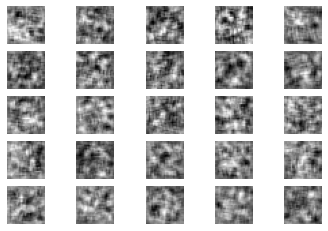

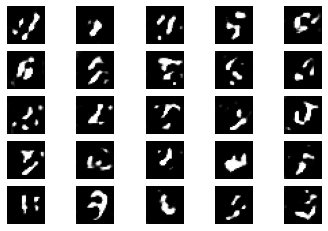

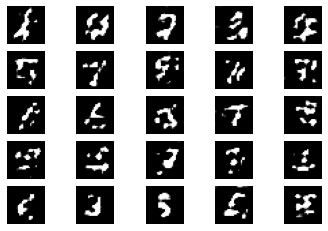

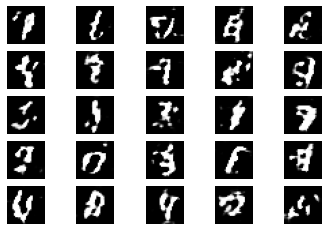

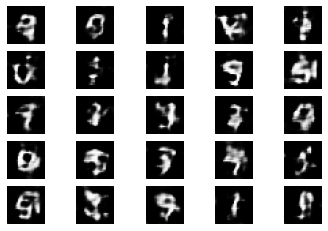

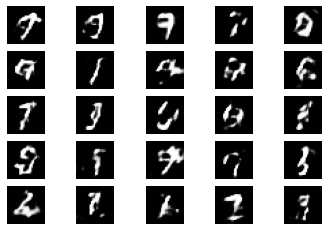

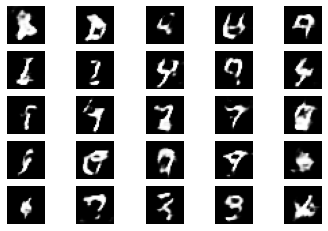

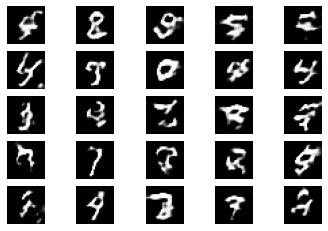

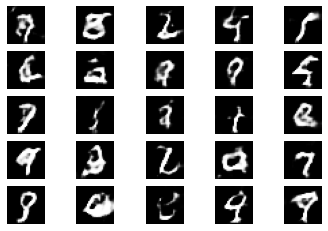

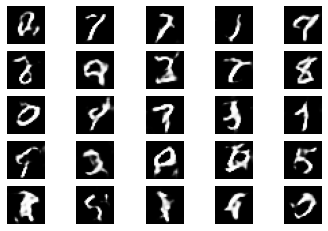

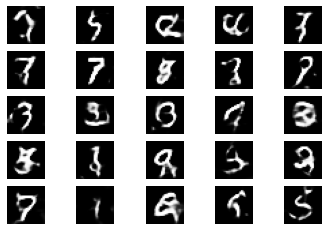

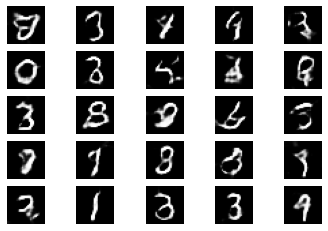

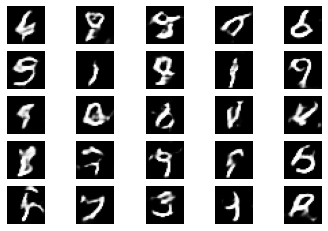

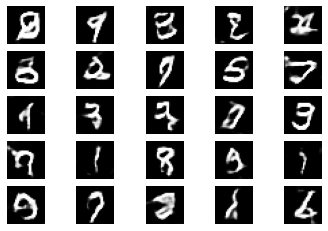

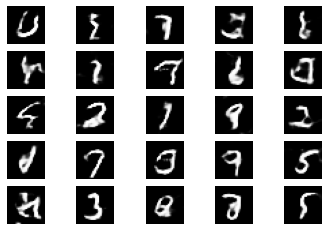

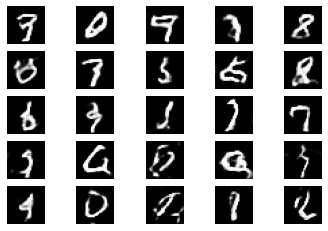

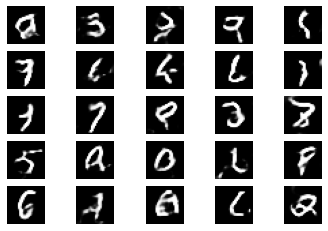

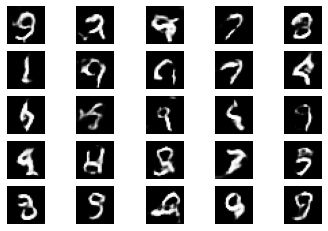

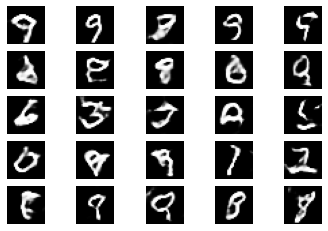

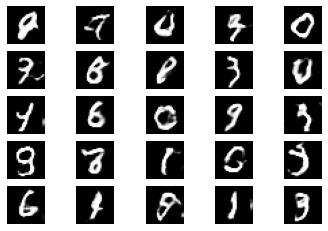

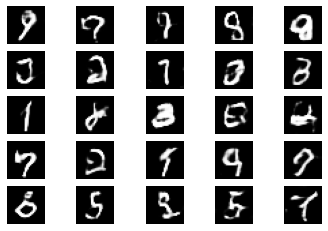

In [10]:
gan_train(4001, 32, 200)